In [40]:
!apt -qq -y install fonts-nanum
# ✅ 나눔고딕 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [2]:
!pip install -q transformers datasets sentencepiece scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [3]:
# ✅ 기본 라이브러리
import os
import re
import numpy as np
import pandas as pd
from datetime import datetime

# ✅ 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# ✅ 머신러닝 / 자연어처리
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch

# ✅ Weights & Biases 비활성화 (옵션)
os.environ['WANDB_DISABLED'] = 'true'

# # ✅ 나눔고딕 폰트 설정
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# fm.fontManager.addfont(font_path)
# plt.rc('font', family='NanumGothic')
# plt.rcParams['axes.unicode_minus'] = False

In [4]:
df = pd.read_csv('/content/toss_삼성.csv')
df = df.copy()
df = df.fillna('')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143800 entries, 0 to 143799
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Comment ID  143800 non-null  int64 
 1   Message     143800 non-null  object
 2   Updated At  143800 non-null  object
 3   Nickname    143800 non-null  object
 4   Platform    143800 non-null  object
 5   Stock Name  143800 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.6+ MB


In [6]:
# ✅ 2. 정치/혐오 키워드 파일 불러오기
with open('/content/political_keywords.txt', 'r', encoding='utf-8') as f:
    political_keywords = [line.strip() for line in f.readlines() if line.strip()]

# ✅ 3. 필터링 함수 정의
def contains_political(text):
    text = re.sub(r'\s+', '', str(text))  # 공백 제거
    return any(p in text for p in political_keywords)

def contains_url(text):
    return bool(re.search(r'https?://|www\.|\.com|\.kr', str(text)))

# ✅ 4. 전처리 함수 정의
def clean_for_tfidf(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_for_bert(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s!?.,ㄱ-ㅎㅏ-ㅣ가-힣]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ✅ 5. 통합 처리 함수 (필터링 + 전처리 + 시간 컬럼 유지)
def preprocess_row(row):
    text = row['Message']
    timestamp = row['Updated At']

    if contains_political(text) or contains_url(text):
        return None, None, None, None
    return text, clean_for_tfidf(text), clean_for_bert(text), timestamp

# ✅ 6. 적용 및 결과 구성
processed = df[["Message", "Updated At"]].apply(preprocess_row, axis=1, result_type='expand')
processed.columns = ['text', 'text_tfidf', 'text_bert', 'time']
filtered_df = processed.dropna().reset_index(drop=True)

print(f"✅ 최종 필터링 및 전처리 완료! 남은 댓글 수: {len(filtered_df)}")

✅ 최종 필터링 및 전처리 완료! 남은 댓글 수: 135146


In [7]:
filtered_df.to_csv('filtered_df_toss_samsung.csv', encoding='utf-8-sig', index=False)

In [8]:
filtered_df.head(10)

,text,text_tfidf,text_bert,time
0,대재용,대재용,대재용,2025-03-23T02:06:11+09:00
1,월요일.. 오르나요?,월요일 오르나요,월요일.. 오르나요?,2025-03-23T00:53:55+09:00
2,1. 일 같이하는게 맘에 안들면 조용히 몇일써보고 짜르면 되는데.\n\n욕은 몇일안...,1 일 같이하는게 맘에 안들면 조용히 몇일써보고 짜르면 되는데 욕은 몇일안에 1년치...,1. 일 같이하는게 맘에 안들면 조용히 몇일써보고 짜르면 되는데. 욕은 몇일안에 1...,2025-03-22T22:26:06+09:00
3,8만은 오겠지만 장기 봐야하고 이번달은 65000-66000은 터치할듯. 난 66...,8만은 오겠지만 장기 봐야하고 이번달은 6500066000은 터치할듯 난 66000...,8만은 오겠지만 장기 봐야하고 이번달은 6500066000은 터치할듯. 난 6600...,2025-03-22T22:23:54+09:00
4,1.이평선 수렴 거의했고\n2.60/120 골든크로스만 남았다\n3.하락추세 밖...,1이평선 수렴 거의했고 260120 골든크로스만 남았다 3하락추세 밖 전고돌파했다 ...,1.이평선 수렴 거의했고 2.60120 골든크로스만 남았다 3.하락추세 밖 전고돌파...,2025-03-22T20:59:04+09:00
5,삼전 ROE는 10퍼도 안 나오는데 자기자본비율은 70퍼 넘네\n배당 좀 해라 주주...,삼전 ROE는 10퍼도 안 나오는데 자기자본비율은 70퍼 넘네 배당 좀 해라 주주도...,삼전 ROE는 10퍼도 안 나오는데 자기자본비율은 70퍼 넘네 배당 좀 해라 주주도...,2025-03-22T20:43:59+09:00
6,음 그래프를 보면 다시 8만 가야되긴 하는데,음 그래프를 보면 다시 8만 가야되긴 하는데,음 그래프를 보면 다시 8만 가야되긴 하는데,2025-03-22T20:29:43+09:00
7,삼전은 더오를일만 남았다 삼전은 걱정할필요가없다 근데 삼전만 살것인가?\n일단은 수...,삼전은 더오를일만 남았다 삼전은 걱정할필요가없다 근데 삼전만 살것인가 일단은 수익내...,삼전은 더오를일만 남았다 삼전은 걱정할필요가없다 근데 삼전만 살것인가? 일단은 수익...,2025-03-22T18:47:08+09:00
8,모냐 왜 올랐냐,모냐 왜 올랐냐,모냐 왜 올랐냐,2025-03-22T18:44:45+09:00
9,마이너스 탈출했네,마이너스 탈출했네,마이너스 탈출했네,2025-03-22T18:10:36+09:00


<Figure size 800x600 with 0 Axes>

<Axes: xlabel='score', ylabel='word'>

Text(0.5, 1.0, 'TF-IDF 상위 주식 키워드')

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

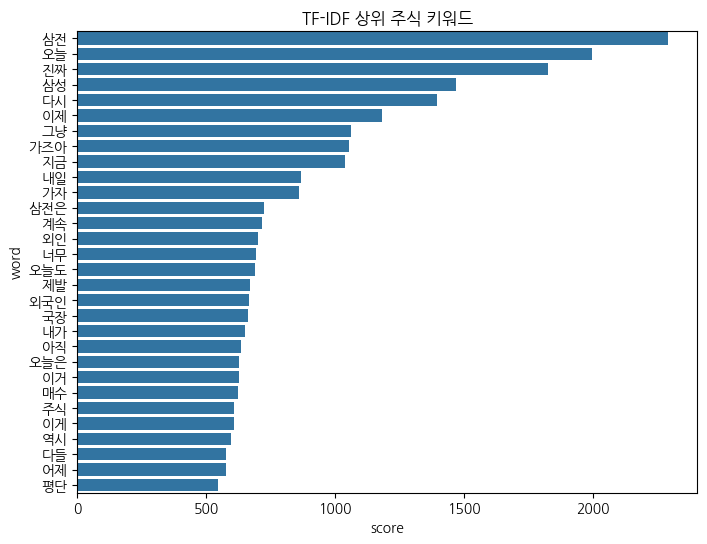

In [ ]:
# ✅ TF-IDF 기반 주식 키워드 추출 (토스삼전 정제 댓글 기준)
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(filtered_df['text_tfidf'])

scores = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
tfidf_df = pd.DataFrame(sorted(scores, key=lambda x: -x[1])[:30], columns=['word', 'score'])

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(data=tfidf_df, x='score', y='word')
plt.title('TF-IDF 상위 주식 키워드')
plt.tight_layout

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='count', ylabel='word'>

Text(0.5, 1.0, '단어 등장 빈도 상위 30개 (토스 삼전 댓글)')

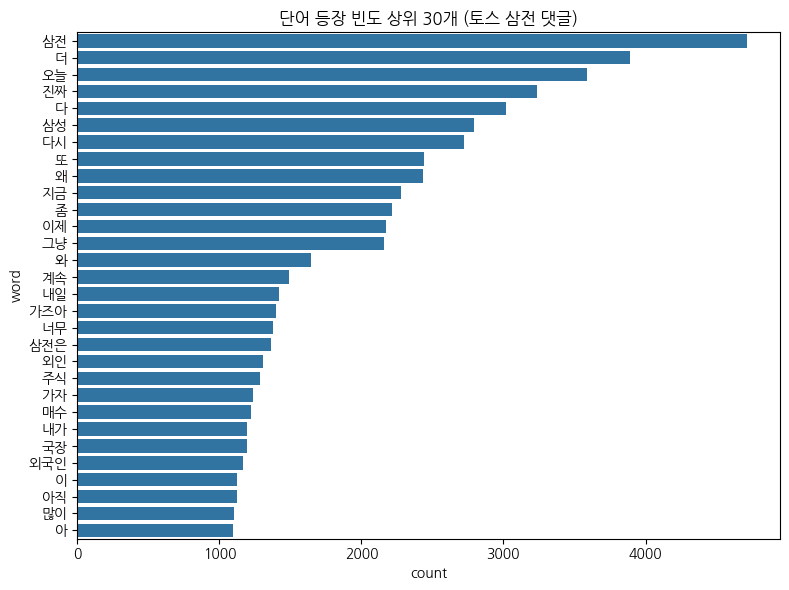

In [ ]:
from collections import Counter

# 텍스트 정제 함수
def clean_text(text):
    text = re.sub(r"[^\uAC00-\uD7A3a-zA-Z0-9\s]", "", text)  # 한글, 영문, 숫자만 남김
    return text.lower()

# 텍스트 전처리 후 단어 리스트 생성
all_words = []
for doc in filtered_df['text_tfidf'].dropna():
    cleaned = clean_text(doc)
    words = cleaned.split()
    all_words.extend(words)

# 단어 빈도 계산
word_freq = Counter(all_words)
common_words = word_freq.most_common(50)

# 데이터프레임 변환
freq_df = pd.DataFrame(common_words, columns=['word', 'count'])

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(data=freq_df, x='count', y='word')
plt.title("단어 등장 빈도 상위 50개 (토스 삼전 댓글)")
plt.tight_layout()
plt.show()


In [10]:
# ✅ 1. 감정 키워드 불러오기
with open("/content/fear_keywords.txt", "r", encoding="utf-8") as f:
    fear_keywords = set([line.strip() for line in f if line.strip()])

with open("/content/greed_keywords.txt", "r", encoding="utf-8") as f:
    greed_keywords = set([line.strip() for line in f if line.strip()])

# ✅ 2. 정제 함수
def clean_text_for_labeling(text):
    return re.sub(r"[^\uAC00-\uD7A3a-zA-Z0-9\\s]", " ", str(text)).lower()

# ✅ 3. 단어 수 기반 약한 라벨링 (정수 반환: 0=공포, 1=중립, 2=탐욕)
def weak_label_by_count(text):
    text_clean = clean_text_for_labeling(text)
    fear_count = sum(word in text_clean for word in fear_keywords)
    greed_count = sum(word in text_clean for word in greed_keywords)

    if fear_count > greed_count:
        return 0  # 공포
    elif greed_count > fear_count:
        return 2  # 탐욕
    elif fear_count == greed_count and fear_count > 0:
        return 1  # 중립
    else:
        return 1  # 중립

# ✅ 4. 약한 라벨링 적용
filtered_df["label"] = filtered_df["text"].apply(weak_label_by_count)

# ✅ 5. 전체 분포 확인
print("전체 분포:\n", filtered_df["label"].value_counts().sort_index())  # 0=공포, 1=중립, 2=탐욕

# # ✅ 6. 이진 분류용 데이터셋 만들기 (중립 제외)
# binary_df = filtered_df[filtered_df["label"].isin([0, 2])].copy()
# binary_df["label"] = binary_df["label"].map({0: 0, 2: 1})  # 공포=0, 탐욕=1

# # ✅ 7. 이진 분포 확인
# print("이진 분포:\n", binary_df["label"].value_counts())

전체 분포:
 label
0    19125
1    90891
2    25130
Name: count, dtype: int64


In [11]:
filtered_df.to_csv("filtered_df_labeled_toss_samsung.csv", index=False, encoding="utf-8-sig")

In [12]:
# ✅ 텍스트와 라벨만 추출
train_data = filtered_df[["text", "label"]].copy()

# ✅ stratify로 클래스 비율 유지하며 분할
train_df, valid_df = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data["label"],
    random_state=42
)

# ✅ 저장
train_df.to_csv("train_3class.csv", index=False)
valid_df.to_csv("valid_3class.csv", index=False)

# ✅ 확인
print("Train 분포:\n", train_df["label"].value_counts())
print("Valid 분포:\n", valid_df["label"].value_counts())

Train 분포:
 label
1    72712
2    20104
0    15300
Name: count, dtype: int64
Valid 분포:
 label
1    18179
2     5026
0     3825
Name: count, dtype: int64


In [13]:
from datasets import load_dataset

# ✅ 1. 모델과 토크나이저 로딩
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ 2. 데이터셋 불러오기
dataset = load_dataset("csv", data_files={"train": "train_3class.csv", "validation": "valid_3class.csv"})

# ✅ 3. 토큰화 함수 정의
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# ✅ 4. 토큰화 적용
tokenized_dataset = dataset.map(tokenize_function)

# ✅ 5. 모델 정의 (3 클래스 분류)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/250k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/108116 [00:00<?, ? examples/s]

Map:   0%|          | 0/27030 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# 샘플데이터로 진행
# ✅ 기존 train_df / valid_df에서 샘플링
sample_train = train_df.sample(3000, random_state=42)
sample_valid = valid_df.sample(1000, random_state=42)

# ✅ 저장
sample_train.to_csv("train_3class_test.csv", index=False)
sample_valid.to_csv("valid_3class_test.csv", index=False)

from datasets import load_dataset

# ✅ 데이터 로드
dataset = load_dataset("csv", data_files={
    "train": "train_3class_test.csv",
    "validation": "valid_3class_test.csv"
})

# ✅ 토크나이징 함수 (이미 정의돼 있다면 생략 가능)
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# ✅ 토큰화 적용
tokenized_dataset = dataset.map(tokenize_function)

# 모델정의
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 학습설정+trainer 구성
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./kcbert_3class_test_model",
    evaluation_strategy="epoch",
    save_strategy="no",  # 테스트용 → 저장 안 함
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    logging_dir="./logs_test",
    logging_steps=20
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer
)

# ✅ 학습 시작
trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-14-66949860ba5f>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.577700,0.594726


TrainOutput(global_step=188, training_loss=0.7219881478776323, metrics={'train_runtime': 66.0574, 'train_samples_per_second': 45.415, 'train_steps_per_second': 2.846, 'total_flos': 197335063296000.0, 'train_loss': 0.7219881478776323, 'epoch': 1.0})

In [ ]:
# # 3. 학습세팅 및 Trainer 구성
# training_args = TrainingArguments(
#     output_dir="./kcbert_3class_model",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     num_train_epochs=3,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     learning_rate=2e-5,
#     logging_dir="./logs",
#     logging_steps=20,
#     load_best_model_at_end=True,
#     save_total_limit=1,
#     metric_for_best_model="eval_loss"
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_dataset["train"],
#     eval_dataset=tokenized_dataset["validation"],
#     tokenizer=tokenizer
# )

# # ✅ 학습 시작
# trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-14-d8dfa0531419>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.049200,0.077738
2,0.023300,0.073068
3,0.000800,0.090147


TrainOutput(global_step=6639, training_loss=0.06413937875030469, metrics={'train_runtime': 2467.5546, 'train_samples_per_second': 43.043, 'train_steps_per_second': 2.691, 'total_flos': 6986387852974080.0, 'train_loss': 0.06413937875030469, 'epoch': 3.0})

In [20]:
def predict_fear_greed_3class(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # ✅ 입력도 model과 같은 device로 보내기 (GPU)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).squeeze().tolist()

    fear = probs[0]
    neutral = probs[1]
    greed = probs[2]

    score = fear * 0 + neutral * 50 + greed * 100

    return {
        "공포": round(fear, 4),
        "중립": round(neutral, 4),
        "탐욕": round(greed, 4),
        "공포탐욕지수": round(score, 2)
    }

In [22]:
predict_fear_greed_3class("와 진짜 폭락하네.. 미치겠다")
predict_fear_greed_3class("추가매수 타이밍인가?")
predict_fear_greed_3class("뭐가 어떻게 되는 거야?")
predict_fear_greed_3class("대박 간다 상한가")

{'공포': 0.4659, '중립': 0.2656, '탐욕': 0.2686, '공포탐욕지수': 40.13}

{'공포': 0.2942, '중립': 0.2271, '탐욕': 0.4786, '공포탐욕지수': 59.22}

{'공포': 0.0535, '중립': 0.9268, '탐욕': 0.0197, '공포탐욕지수': 48.31}

{'공포': 0.0416, '중립': 0.0571, '탐욕': 0.9013, '공포탐욕지수': 92.98}

In [25]:
from tqdm import tqdm
def batch_predict_3class(df, text_column="text", batch_size=64):
    results = {
        "공포 확률": [],
        "중립 확률": [],
        "탐욕 확률": [],
        "공포탐욕지수": []
    }

    model.eval()

    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df[text_column].iloc[i:i+batch_size].tolist()

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(model.device)  # ✅ 입력도 GPU로 이동

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)

        fears = probs[:, 0].tolist()
        neutrals = probs[:, 1].tolist()
        greeds = probs[:, 2].tolist()
        scores = [round(n * 50 + g * 100, 2) for n, g in zip(neutrals, greeds)]

        results["공포 확률"].extend([round(f, 4) for f in fears])
        results["중립 확률"].extend([round(n, 4) for n in neutrals])
        results["탐욕 확률"].extend([round(g, 4) for g in greeds])
        results["공포탐욕지수"].extend(scores)

    return pd.DataFrame(results)

# ✅ 전체 배치 예측 (filtered_df는 그대로)
pred_df = batch_predict_3class(filtered_df)

# ✅ 예측 결과만 저장
pred_df.to_csv("inference_results_3class.csv", index=False, encoding="utf-8-sig")

100%|██████████| 2112/2112 [09:05<00:00,  3.87it/s]


In [26]:
pred_df.head(10)

,공포 확률,중립 확률,탐욕 확률,공포탐욕지수
0,0.0522,0.8999,0.0480,49.79
1,0.1259,0.4485,0.4256,64.99
2,0.1651,0.6506,0.1843,50.96
3,0.4204,0.3928,0.1868,38.32
4,0.1649,0.0515,0.7837,80.94
5,0.1778,0.6377,0.1844,50.33
6,0.0660,0.7566,0.1774,55.57
7,0.1721,0.2917,0.5362,68.20
8,0.2490,0.5578,0.1932,47.21
9,0.3491,0.5100,0.1410,39.59


In [28]:
# ✅ index 기준으로 병합 (reset_index 필요할 수도 있음)
combined_df = pd.concat([filtered_df.reset_index(drop=True), pred_df.reset_index(drop=True)], axis=1)

# ✅ 결과 확인
combined_df.head(10)

# 저장
combined_df.to_csv("combined_with_text_and_inference_3class.csv", index=False, encoding="utf-8-sig")

,text,text_tfidf,text_bert,time,label,공포 확률,중립 확률,탐욕 확률,공포탐욕지수
0,대재용,대재용,대재용,2025-03-23T02:06:11+09:00,1,0.0522,0.8999,0.0480,49.79
1,월요일.. 오르나요?,월요일 오르나요,월요일.. 오르나요?,2025-03-23T00:53:55+09:00,1,0.1259,0.4485,0.4256,64.99
2,1. 일 같이하는게 맘에 안들면 조용히 몇일써보고 짜르면 되는데.\n\n욕은 몇일안...,1 일 같이하는게 맘에 안들면 조용히 몇일써보고 짜르면 되는데 욕은 몇일안에 1년치...,1. 일 같이하는게 맘에 안들면 조용히 몇일써보고 짜르면 되는데. 욕은 몇일안에 1...,2025-03-22T22:26:06+09:00,1,0.1651,0.6506,0.1843,50.96
3,8만은 오겠지만 장기 봐야하고 이번달은 65000-66000은 터치할듯. 난 66...,8만은 오겠지만 장기 봐야하고 이번달은 6500066000은 터치할듯 난 66000...,8만은 오겠지만 장기 봐야하고 이번달은 6500066000은 터치할듯. 난 6600...,2025-03-22T22:23:54+09:00,0,0.4204,0.3928,0.1868,38.32
4,1.이평선 수렴 거의했고\n2.60/120 골든크로스만 남았다\n3.하락추세 밖...,1이평선 수렴 거의했고 260120 골든크로스만 남았다 3하락추세 밖 전고돌파했다 ...,1.이평선 수렴 거의했고 2.60120 골든크로스만 남았다 3.하락추세 밖 전고돌파...,2025-03-22T20:59:04+09:00,2,0.1649,0.0515,0.7837,80.94
5,삼전 ROE는 10퍼도 안 나오는데 자기자본비율은 70퍼 넘네\n배당 좀 해라 주주...,삼전 ROE는 10퍼도 안 나오는데 자기자본비율은 70퍼 넘네 배당 좀 해라 주주도...,삼전 ROE는 10퍼도 안 나오는데 자기자본비율은 70퍼 넘네 배당 좀 해라 주주도...,2025-03-22T20:43:59+09:00,1,0.1778,0.6377,0.1844,50.33
6,음 그래프를 보면 다시 8만 가야되긴 하는데,음 그래프를 보면 다시 8만 가야되긴 하는데,음 그래프를 보면 다시 8만 가야되긴 하는데,2025-03-22T20:29:43+09:00,1,0.0660,0.7566,0.1774,55.57
7,삼전은 더오를일만 남았다 삼전은 걱정할필요가없다 근데 삼전만 살것인가?\n일단은 수...,삼전은 더오를일만 남았다 삼전은 걱정할필요가없다 근데 삼전만 살것인가 일단은 수익내...,삼전은 더오를일만 남았다 삼전은 걱정할필요가없다 근데 삼전만 살것인가? 일단은 수익...,2025-03-22T18:47:08+09:00,2,0.1721,0.2917,0.5362,68.20
8,모냐 왜 올랐냐,모냐 왜 올랐냐,모냐 왜 올랐냐,2025-03-22T18:44:45+09:00,1,0.2490,0.5578,0.1932,47.21
9,마이너스 탈출했네,마이너스 탈출했네,마이너스 탈출했네,2025-03-22T18:10:36+09:00,0,0.3491,0.5100,0.1410,39.59


In [29]:
# ✅ 예측 함수 실행 (text_bert 기준)
pred_df = batch_predict_3class(filtered_df, text_column="text_bert")

# ✅ 예측 결과 + 댓글(text_bert) 합치기
final_df = pd.concat([
    filtered_df[["text_bert"]].reset_index(drop=True),  # 댓글
    pred_df.reset_index(drop=True)                      # 확률 + 지수
], axis=1)

# ✅ 저장
final_df.to_csv("final_test_text_bert.csv", index=False, encoding="utf-8-sig")

# ✅ 확인
final_df.head()

100%|██████████| 2112/2112 [08:59<00:00,  3.91it/s]


,text_bert,공포 확률,중립 확률,탐욕 확률,공포탐욕지수
0,대재용,0.0522,0.8999,0.0480,49.79
1,월요일.. 오르나요?,0.1259,0.4485,0.4256,64.99
2,1. 일 같이하는게 맘에 안들면 조용히 몇일써보고 짜르면 되는데. 욕은 몇일안에 1...,0.1548,0.6697,0.1755,51.04
3,8만은 오겠지만 장기 봐야하고 이번달은 6500066000은 터치할듯. 난 6600...,0.4166,0.4007,0.1827,38.30
4,1.이평선 수렴 거의했고 2.60120 골든크로스만 남았다 3.하락추세 밖 전고돌파...,0.1677,0.0527,0.7796,80.60


In [30]:
# ✅ 1. 시간 정보 붙이기
final_df["time"] = filtered_df["time"].reset_index(drop=True)

# ✅ 2. datetime 형식으로 변환 (혹시 문자열일 경우)
final_df["time"] = pd.to_datetime(final_df["time"])

# ✅ 3. 시간 단위로 묶기
final_df["hour"] = final_df["time"].dt.floor("H")

# ✅ 4. 시간대별 평균 지수 계산
hourly_avg = final_df.groupby("hour")["공포탐욕지수"].mean().reset_index()

# ✅ 5. 저장
hourly_avg.to_csv("hourly_feargreed_score_bert.csv", index=False, encoding="utf-8-sig")


<ipython-input-30-82617163a840>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  final_df["hour"] = final_df["time"].dt.floor("H")


In [35]:
hourly_avg.info()
hourly_avg.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9476 entries, 0 to 9475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype                    
---  ------  --------------  -----                    
 0   hour    9476 non-null   datetime64[ns, UTC+09:00]
 1   공포탐욕지수  9476 non-null   float64                  
dtypes: datetime64[ns, UTC+09:00](1), float64(1)
memory usage: 148.2 KB


,hour,공포탐욕지수
0,2023-05-25 12:00:00+09:00,46.916667
1,2023-05-25 13:00:00+09:00,60.906250
2,2023-05-25 14:00:00+09:00,61.989167
3,2023-05-25 15:00:00+09:00,62.502500
4,2023-05-25 16:00:00+09:00,51.030000


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, '2025-03-17 ~ 2025-03-23 시간대별 평균 공포탐욕지수')

Text(0.5, 0, '시간')

Text(0, 0.5, '공포탐욕지수 (0~100)')

(array([20164., 20165., 20166., 20167., 20168., 20169., 20170.]),
 [Text(20164.0, 0, '2025-03-17'),
  Text(20165.0, 0, '2025-03-18'),
  Text(20166.0, 0, '2025-03-19'),
  Text(20167.0, 0, '2025-03-20'),
  Text(20168.0, 0, '2025-03-21'),
  Text(20169.0, 0, '2025-03-22'),
  Text(20170.0, 0, '2025-03-23')])

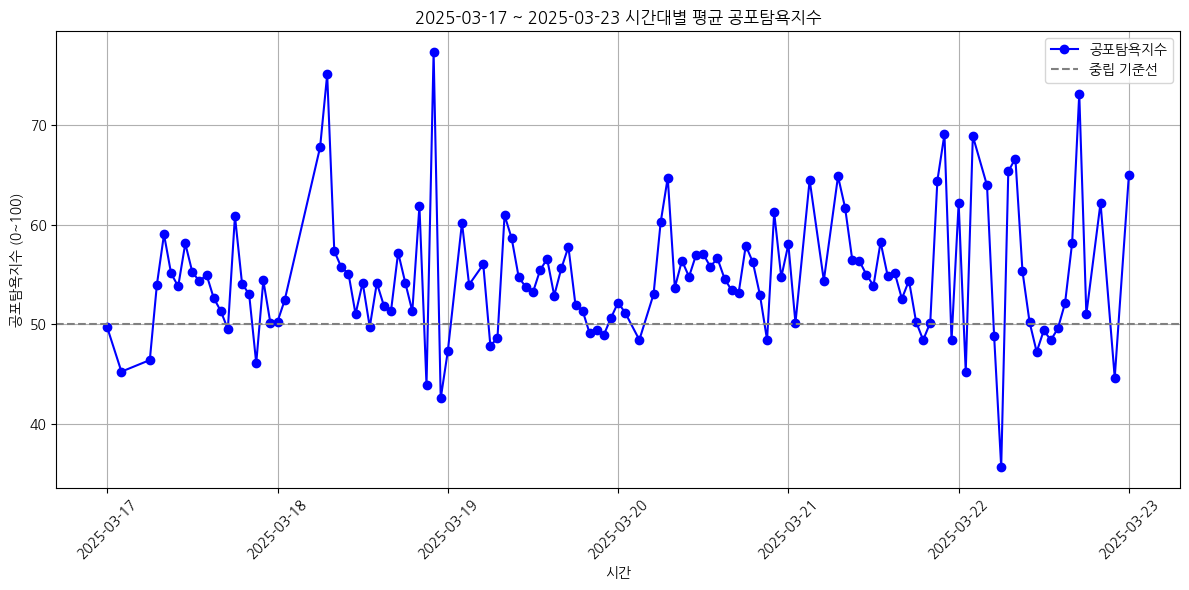

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 날짜 범위 지정
latest = hourly_avg["hour"].max().normalize()
week_ago = latest - pd.Timedelta(days=6)

# ✅ 최근 1주일 데이터 필터링
weekly_avg = hourly_avg[(hourly_avg["hour"] >= week_ago) & (hourly_avg["hour"] <= latest)].copy()

# ✅ 타임존 제거 (혹시 남아있다면)
weekly_avg["hour"] = pd.to_datetime(weekly_avg["hour"])
weekly_avg["hour"] = weekly_avg["hour"].dt.tz_localize(None)

# ✅ 시각화
plt.figure(figsize=(12, 6))
plt.plot(weekly_avg["hour"], weekly_avg["공포탐욕지수"], marker='o', linestyle='-', color='blue', label='공포탐욕지수')
plt.title(f"{week_ago.date()} ~ {latest.date()} 시간대별 평균 공포탐욕지수")
plt.xlabel("시간")
plt.ylabel("공포탐욕지수 (0~100)")
plt.axhline(50, color='gray', linestyle='--', label="중립 기준선")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
weekly_avg = weekly_avg.sort_values("hour").reset_index(drop=True)
weekly_avg.to_csv('weekly_avg.csv', encoding='utf-8-sig', index=False)

In [45]:
plt.savefig("fear_greed_index_weekly.png", dpi=300)

<Figure size 640x480 with 0 Axes>

In [ ]:
# ✅ 학습된 모델 로드
model_path = "./kcbert_binary_model/checkpoint-4426"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# 예측함수
def predict_fear_greed_binary(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).squeeze().tolist()

    fear = probs[0]
    greed = probs[1]
    score = greed * 100

    return {
        "공포 확률": round(fear, 4),
        "탐욕 확률": round(greed, 4),
        "공포탐욕지수": round(score, 2)
    }

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# ✅ 예시
predict_fear_greed_binary("와 진짜 폭락하네.. 미치겠다")
predict_fear_greed_binary("추가매수 타이밍인가")
predict_fear_greed_binary("상한가 가보자고!!!")
predict_fear_greed_binary("추매 타이밍?")
predict_fear_greed_binary("뭐가 어떻게되는거야?")
predict_fear_greed_binary("살지말지 알려줘")

{'공포 확률': 0.9999, '탐욕 확률': 0.0001, '공포탐욕지수': 0.01}

{'공포 확률': 0.0, '탐욕 확률': 1.0, '공포탐욕지수': 100.0}

{'공포 확률': 0.0, '탐욕 확률': 1.0, '공포탐욕지수': 100.0}

{'공포 확률': 0.9998, '탐욕 확률': 0.0002, '공포탐욕지수': 0.02}

{'공포 확률': 0.9824, '탐욕 확률': 0.0176, '공포탐욕지수': 1.76}

{'공포 확률': 0.9997, '탐욕 확률': 0.0003, '공포탐욕지수': 0.03}

In [ ]:
from tqdm import tqdm

def batch_predict_binary(df, text_column="text"):
    results = {
        "공포 확률": [],
        "탐욕 확률": [],
        "공포탐욕지수": []
    }

    model.eval()
    for text in tqdm(df[text_column]):
        try:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1).squeeze().tolist()
        except:
            probs = [0.5, 0.5]  # 예외 발생 시 중립 처리

        results["공포 확률"].append(round(probs[0], 4))
        results["탐욕 확률"].append(round(probs[1], 4))
        results["공포탐욕지수"].append(round(probs[1] * 100, 2))

    return pd.DataFrame(results)


In [ ]:
# 예측
pred_df = batch_predict_binary(filtered_df)

# 별도로 저장 (분리된 분석용)
pred_df.to_csv("inference_results_binary.csv", index=False, encoding="utf-8-sig")

# 선택적으로 병합도 가능
combined_df = pd.concat([filtered_df.reset_index(drop=True), pred_df], axis=1)
combined_df.to_csv("combined_with_inference_binary.csv", index=False, encoding="utf-8-sig")


  2%|▏         | 2537/135146 [19:45<14:35:09,  2.53it/s]